In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [2]:
df = pd.read_excel("/Users/tungdiesel/Desktop/datadriven/onlineretail.xlsx")    
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   
df['Month'] = df['InvoiceDate'].dt.month
data = df[(df['Month'] >= 2) & (df['Month'] <= 6)]
data["OrderValue"] = data["UnitPrice"] * data["Quantity"]
display(data)

/var/folders/h4/m7zhf0zn3ns7pgr7n020rz3m0000gn/T/ipykernel_60749/682539904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["OrderValue"] = data["UnitPrice"] * data["Quantity"]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,OrderValue
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,60.00
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom,2,40.32
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom,2,10.08
...,...,...,...,...,...,...,...,...,...,...
245898,558637,22032,BOTANICAL LILY GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245899,558637,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245900,558637,22033,BOTANICAL ROSE GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245901,558637,22029,SPACEBOY BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04


In [3]:
num_items = data['Description'].nunique()   # đếm số lượng các mặt hàng
print(num_items)



3380


In [4]:
# tính tổng số lượng các mặt hàng đã bán
item_sales = (
    data.groupby('Description')  # nhóm theo tên hàng
      ['Quantity']             # chọn cột Quantity
      .sum()                   # tính tổng
      .sort_values(ascending=False)  # sắp xếp
)

top_items = item_sales.head(10) # lấy 10 mặt hàng bán nhiều nhất

other_total = item_sales.iloc[10:].sum() # tính tổng số lượng của các loại hàng còn lại

final_sales = pd.concat([top_items, pd.Series({'Other': other_total})]) # tạo series mới gồm top 10 và nhóm 'Other'
print(final_sales)

WORLD WAR 2 GLIDERS ASSTD DESIGNS       23564
JUMBO BAG RED RETROSPOT                 18104
ASSORTED COLOURS SILK FAN               15360
SMALL POPCORN HOLDER                    15292
PACK OF 72 RETROSPOT CAKE CASES         14371
PACK OF 12 LONDON TISSUES               12501
PACK OF 60 PINK PAISLEY CAKE CASES      12318
ASSORTED COLOUR BIRD ORNAMENT           11475
WHITE HANGING HEART T-LIGHT HOLDER      11445
VICTORIAN GLASS HANGING T-LIGHT         10484
Other                                 1501869
dtype: int64


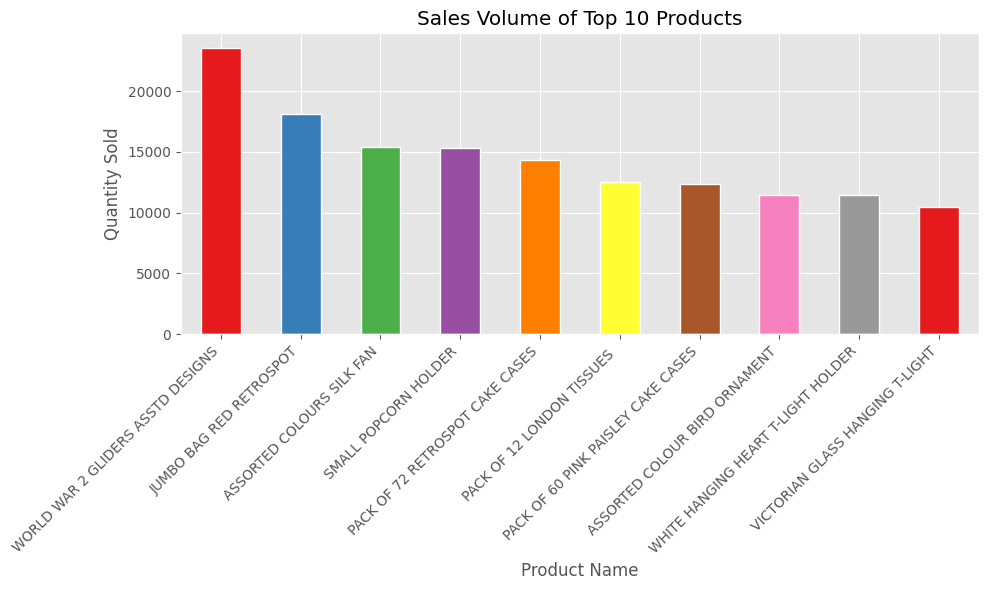

In [5]:
plt.style.use('ggplot') #chọn theme biểu đồ

colors = sns.color_palette('Set1', n_colors=10) #chọn palette màu

top_items.plot(
    kind='bar',
    figsize=(10, 6),  
    color=colors,
    edgecolor='white',
    linewidth=1
)
plt.title('Sales Volume of Top 10 Products')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc
plt.tight_layout()  # Điều chỉnh layout
plt.show()

In [7]:
# bỏ các đơn hàng bị hủy (InvoiceNo bắt đầu bằng 'C')
data = (
    data[data['InvoiceNo'].notna() &    # truy cập cột InvoiceNo, lấy các phần tử không phải NaN và
         ~data['InvoiceNo']             # truy cập cột InvoiceNo, lấy các phần tử không phải bắt đầu với "C"
         .astype(str)                   # đổi dạng thành chuỗi kí tự
         .str.startswith('C')]          # kiểm tra xem chuỗi có bắt đầu bằng "C" hay không
)

# gộp các mã sản phẩm (StockCode) theo đơn hàng
stockcode_joined = (
    data.groupby('InvoiceNo')['StockCode']          # nhóm theo cột InvoiceNo, sau đó truy cập cột Stockcode
    .apply(lambda x: ', '.join(x.astype(str)))      # lấy các StockCode cho về dạng chuỗi, rồi viết liền thành 1 dòng phân cách bởi dấu ","
    .reset_index(name='StockCodes')                 # trả về cột StockCode không phải dạng index
)

# gộp các mô tả sản phẩm (Description) theo đơn hàng, tương tự như đoạn trên
description_joined = (
    data.groupby('InvoiceNo')['Description']
    .apply(lambda x: ', '.join(x.astype(str)))
    .reset_index(name='Descriptions')
)

# tổng giá trị hóa đơn
invoice_total = (
    data.groupby('InvoiceNo')['OrderValue'].sum()
    .reset_index(name='TotalOrderValue')
)
# số lượng sản phẩm trong mỗi hóa đơn
item_counts = (
    data.groupby('InvoiceNo').size()
    .reset_index(name='ItemCount')
)

invoice_summary = (
    data[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country']]
    .drop_duplicates(subset='InvoiceNo')
)

# gộp tất cả lại
invoice_summary = (
    invoice_summary
    .merge(invoice_total, on='InvoiceNo', how='left')
    .merge(item_counts, on='InvoiceNo', how='left')
    .merge(stockcode_joined, on='InvoiceNo', how='left')
    .merge(description_joined, on='InvoiceNo', how='left')
)

# sắp xếp theo thời gian (tăng dần)
invoice_summary = (
    invoice_summary
    .sort_values(by='InvoiceDate', ascending=True)
    
)

# sửa index lại để bắt đầu từ 1
invoice_summary.index = range(1, len(invoice_summary) + 1)

# Xem kết quả
display(invoice_summary.tail(20))


,InvoiceNo,InvoiceDate,CustomerID,Country,TotalOrderValue,ItemCount,StockCodes,Descriptions
7855,558616,2011-06-30 16:22:00,16045.0,United Kingdom,269.40,16,"22960, 22993, 22961, 22907, 22469, 22171, 7145...","JAM MAKING SET WITH JARS, SET OF 4 PANTRY JELL..."
7856,558619,2011-06-30 16:28:00,14401.0,United Kingdom,316.70,14,"21382, 22287, 22286, 85194S, 23210, 23321, 233...","SET/4 SPRING FLOWER DECORATION, DECORATION WOB..."
7857,558620,2011-06-30 16:39:00,15584.0,United Kingdom,154.65,36,"21257, 21259, 21931, 22411, 85099C, 23202, 850...","VICTORIAN SEWING BOX MEDIUM, VICTORIAN SEWING ..."
7858,558621,2011-06-30 16:43:00,13745.0,United Kingdom,300.04,25,"21382, 75172, 22035, 21507, 21508, 22023, 2203...","SET/4 SPRING FLOWER DECORATION, PAINTED SEA SH..."
7859,558622,2011-06-30 16:51:00,16357.0,United Kingdom,120.05,5,"47566, 21755, 21936, 21643, 23118","PARTY BUNTING, LOVE BUILDING BLOCK WORD, RED R..."
7860,558623,2011-06-30 16:52:00,12395.0,Belgium,163.90,10,"22326, 22661, 21559, 21561, 23307, 22726, 2272...","ROUND SNACK BOXES SET OF4 WOODLAND , CHARLOTTE..."
7861,558624,2011-06-30 17:16:00,14560.0,United Kingdom,17.00,1,22624,IVORY KITCHEN SCALES
7862,558625,2011-06-30 17:29:00,14132.0,United Kingdom,301.06,18,"20761, 20762, 20765, 23191, 21224, 21221, 2203...","BLUE PAISLEY SKETCHBOOK, GREEN FERN SKETCHBOOK..."
7863,558626,2011-06-30 17:34:00,12569.0,Germany,95.28,6,"23242, 23180, 22396, 22403, 22398, POST","TREASURE TIN BUFFALO BILL , MUM'S KITCHEN CLOC..."
7864,558627,2011-06-30 17:40:00,14711.0,United Kingdom,311.86,6,"22823, 22827, 23020, 23014, 23241, 23168","CHEST NATURAL WOOD 20 DRAWERS, RUSTIC SEVENTE..."


In [8]:
print(invoice_summary['TotalOrderValue'].describe()) #bảng summary giống trong R

count     7874.000000
mean       420.543027
std        981.230734
min          0.000000
25%        109.595000
50%        258.150000
75%        447.580000
max      38970.000000
Name: TotalOrderValue, dtype: float64


In [9]:
# Đếm số lần mỗi CustomerID xuất hiện
customer_counts = (
    invoice_summary['CustomerID']
    .value_counts()
    .reset_index(name='InvoiceCount')
    .rename(columns={'index': 'CustomerID'})
)

customer_counts.index = range(1, len(customer_counts) + 1)
display(customer_counts.head(10))
print(customer_counts['InvoiceCount'].describe()) #bảng summary giống trong R

,CustomerID,InvoiceCount
1,12748.0,63
2,14911.0,59
3,17841.0,41
4,14606.0,41
5,13089.0,39
6,12971.0,34
7,15311.0,30
8,13798.0,29
9,14646.0,26
10,16029.0,24


count    2551.000000
mean        2.515092
std         3.456121
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        63.000000
Name: InvoiceCount, dtype: float64
